# This notebook is used to carry out the MSM analysis of myosin with either ATP (ADP.Pi) to dATP (dADP.Pi) bound
This notebook was created by Marcus Hock in order to carry out construction, validation and analysis of prepowerstroke myosin bound to either ADP.Pi or dADP.Pi. The end goal of the analysis is to identify distinct conformations or metastable states that could be used in Brownian dynamics simulations. 

The process follows the general workflow: 
1. Trajectory analysis and featurization 
2. Dimmensionaility reduction using time-lagged independent component analysis (tICA)
3. Clustering and MSM construction including implied timescale analysis 
4. Coarse-graining and additional MSM validation 
5. Sampling from constructed states to be used in Brownian dynamics simulations

This notebook relies heavily on PyEmma and MDtraj as well as other traditional python packages. 

### Importing Necessary Modules 

In [249]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import pyemma
import mdtraj as md
import seaborn as sns

from time import time

import pickle
import datetime
import os

plt.rcdefaults() 
plt.rcParams['axes.grid']

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'

### Loading in ADP and dADP Dataset

In [2]:
adp_top = '/media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_adp_strip.prmtop'
adp_traj_files = ['/media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_adp_1_2us_10ps.nc', 
        '/media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_adp_2_2us_10ps.nc', 
        '/media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_adp_3_2us_10ps.nc']

In [3]:
dadp_top = '/media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_dadp_strip.prmtop'
dadp_traj_files = ['/media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_dadp_1_2us_10ps.nc', 
        '/media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_dadp_2_2us_10ps.nc', 
        '/media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_dadp_3_2us_10ps.nc']

In [ ]:
feature_loops_adp = pyemma.coordinates.featurizer(adp_top)

# Get center of mass of tip of CM loop 
CM_tip = feature_loops_adp.select('resid 404 to 406')
# Get center of mass of base of CM loop
CM_base = feature_loops_adp.select('name CA and resid 413 400')


# Get center of mass of tip of loop 4
loop_4_tip = feature_loops_adp.select('resid 366 to 368')
# Get center of mass of base of loop 4
loop_4_base = feature_loops_adp.select('name CA and resid 361 374')

# Get center of mass of all of loop 2
loop_2_all = feature_loops_adp.select('resid 622 to 644')
# Get center of mass of tip of loop 2
loop_2_tip = feature_loops_adp.select('resid 630 to 633')

# Get center of mass of strut 
strut_COM = feature_loops_adp.select('name CA and resid 597 to 602')

# Define distaces to measure between for the cleft 
cleft_1 = feature_loops_adp.select('name CA and resid 370 540')
cleft_2 = feature_loops_adp.select('name CA and resid 405 540')

feature_loops_adp.add_group_COM([CM_tip, CM_base, loop_4_tip, loop_4_base, loop_2_all, loop_2_tip, strut_COM])

feature_loops_adp.add_distances([cleft_1,cleft_2])



In [ ]:
feature_loops_dadp = pyemma.coordinates.featurizer(dadp_top)

# Get center of mass of tip of CM loop 
CM_tip = feature_loops_dadp.select('resid 404 to 406')
# Get center of mass of base of CM loop
CM_base = feature_loops_dadp.select('name CA and resid 413 400')


# Get center of mass of tip of loop 4
loop_4_tip = feature_loops_dadp.select('resid 366 to 368')
# Get center of mass of base of loop 4
loop_4_base = feature_loops_dadp.select('name CA and resid 361 374')

# Get center of mass of all of loop 2
loop_2_all = feature_loops_dadp.select('resid 622 to 644')
# Get center of mass of tip of loop 2
loop_2_tip = feature_loops_dadp.select('resid 630 to 633')

# Get center of mass of strut 
strut_COM = feature_loops_dadp.select('name CA and resid 597 to 602')

# Define distaces to measure between for the cleft 
cleft_1 = feature_loops_dadp.select('name CA and resid 370 540')
cleft_2 = feature_loops_dadp.select('name CA and resid 405 540')

feature_loops_dadp.add_group_COM([CM_tip, CM_base, loop_4_tip, loop_4_base, loop_2_all, loop_2_tip, strut_COM])

feature_loops_dadp.add_distances([cleft_1,cleft_2])



In [ ]:
feature_loops_dadp.describe()

### Below Cells grab feature data and save it directly from trajectory. Can skip if data already saved. 

In [ ]:
data_adp = pyemma.coordinates.source(adp_traj_files, features=feature_loops_adp, chunksize = 5000)


In [ ]:
Loop_COMs_output = data_adp.get_output()

In [ ]:
f = open('msm_datafiles/all_loop_COMs_adp.pkl','wb')
pickle.dump(Loop_COMs_output, f)
f.close()


In [ ]:
data_dadp = pyemma.coordinates.source(dadp_traj_files, features=feature_loops_dadp, chunksize = 5000)


In [ ]:
Loop_COMs_output = data_dadp.get_output()

In [ ]:
f = open('msm_datafiles/all_loop_COMs_dadp.pkl','wb')
pickle.dump(Loop_COMs_output, f)
f.close()

### Start here to load in precalulated measurements 

In [2]:
import os
pwd = os.getcwd()
pwd


'/home/marcus/Documents/myosin_dynamics/1qvi_MSM'

In [3]:
f = open('msm_datafiles/all_loop_COMs_adp.pkl','rb')
ADP_COMS_output = pickle.load(f)
f.close()

f = open('msm_datafiles/all_loop_COMs_dadp.pkl','rb')
dADP_COMS_output = pickle.load(f)
f.close()

In [4]:
ADP_dADP_COMs_output = [ADP_COMS_output[0],
                        ADP_COMS_output[1],
                        ADP_COMS_output[2],
                        dADP_COMS_output[0],
                        dADP_COMS_output[1],
                        dADP_COMS_output[2]]

In [5]:
inter_region_distances = []
for data_chunk in ADP_dADP_COMs_output:
    new_chunk = []
    for i in range(7):
        for j in range(i+1,7):
            x = np.linalg.norm(data_chunk[:,i*3:i*3+3] - data_chunk[:,j*3:j*3+3], axis = 1)
            new_chunk.append(x)
            
    new_chunk.append(data_chunk[:,21])
    new_chunk.append(data_chunk[:,22])
    new_chunk = np.array(new_chunk).reshape(-1,200000).T
    inter_region_distances.append(new_chunk)

In [6]:
name_list = ['CM_tip', 'CM_base', 'loop_4_tip', 'loop_4_base', 'loop_2_all', 'loop_2_tip', 'strut_COM']
measure_name_list = []
for i in range(7):
    for j in range(i+1,7):
        print('COM {} - {}'.format(name_list[i],name_list[j]))
        measure_name_list.append('COM {} - {}'.format(name_list[i],name_list[j]))
        
measure_name_list.append('DIST: GLN370 CA - LYS540 CA')
measure_name_list.append('DIST: GLY405 CA - LYS540 CA')

COM CM_tip - CM_base
COM CM_tip - loop_4_tip
COM CM_tip - loop_4_base
COM CM_tip - loop_2_all
COM CM_tip - loop_2_tip
COM CM_tip - strut_COM
COM CM_base - loop_4_tip
COM CM_base - loop_4_base
COM CM_base - loop_2_all
COM CM_base - loop_2_tip
COM CM_base - strut_COM
COM loop_4_tip - loop_4_base
COM loop_4_tip - loop_2_all
COM loop_4_tip - loop_2_tip
COM loop_4_tip - strut_COM
COM loop_4_base - loop_2_all
COM loop_4_base - loop_2_tip
COM loop_4_base - strut_COM
COM loop_2_all - loop_2_tip
COM loop_2_all - strut_COM
COM loop_2_tip - strut_COM


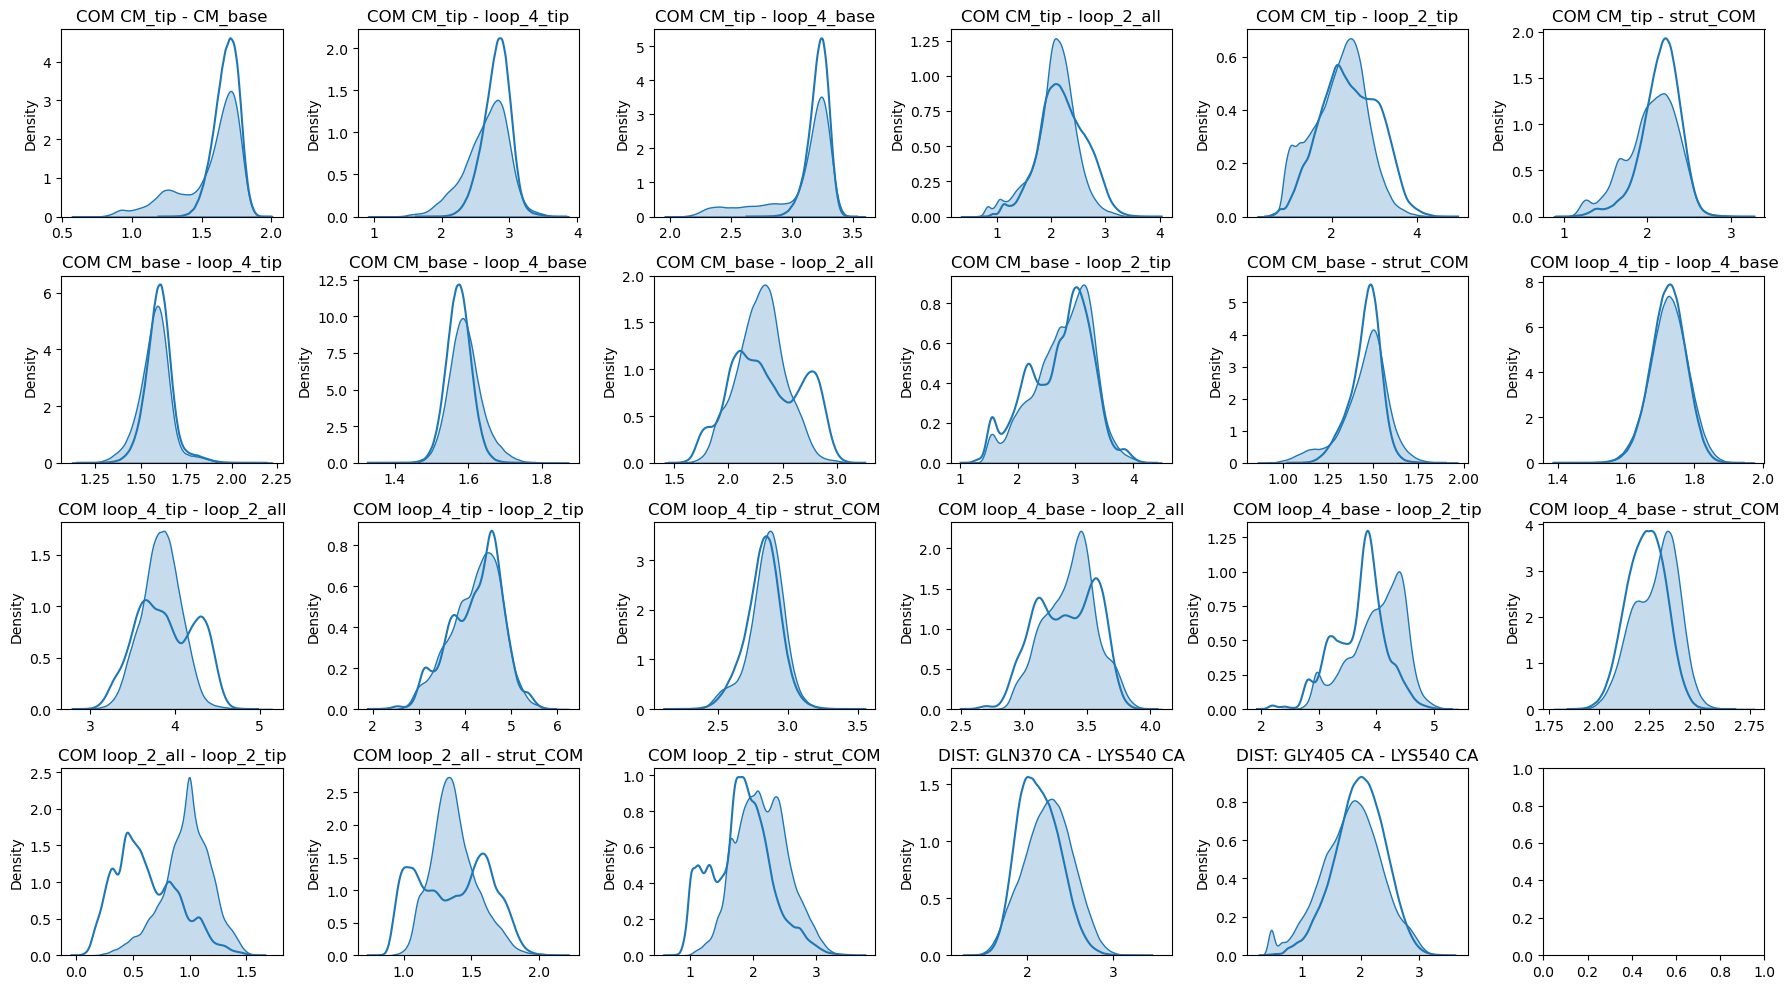

In [8]:
fig, ax = plt.subplots(4,6,figsize = (18,10))

for i in range(23):
    x = i % 6 
    y = i // 6
    ax_sel = ax[y,x]
    sns.kdeplot(np.concatenate(np.array(inter_region_distances)[0:3])[:,i], ax = ax_sel)
    sns.kdeplot(np.concatenate(np.array(inter_region_distances)[3:6])[:,i], ax = ax_sel, fill = True)
    ax_sel.set_title(measure_name_list[i])
    
    
plt.tight_layout()

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='Feature values', ylabel='Feature histograms'>)

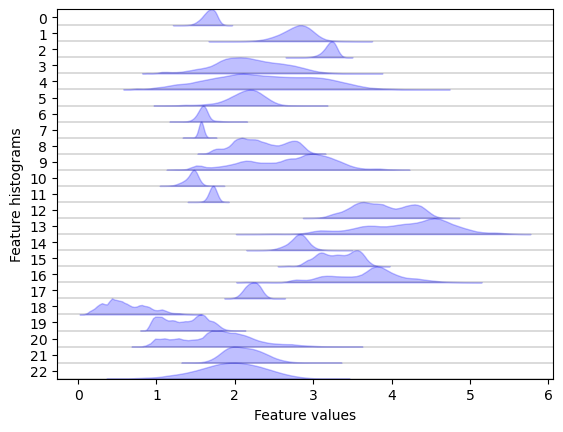

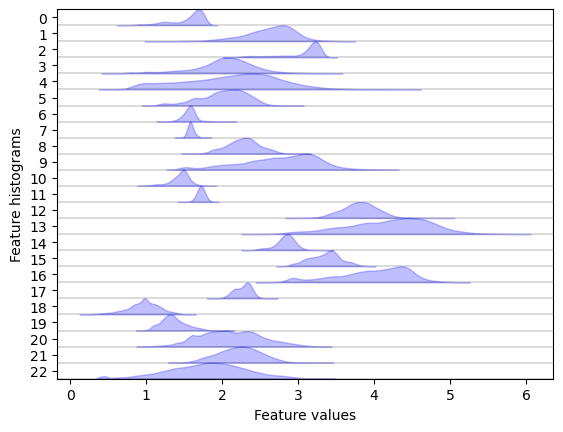

In [7]:
pyemma.plots.plot_feature_histograms(np.concatenate(inter_region_distances[0:3]))
pyemma.plots.plot_feature_histograms(np.concatenate(inter_region_distances[3:6]))

calculate covariances:   0%|                                              | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_239604/1831271406.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


'\nfig, ax = plt.subplots(6,1,figsize = (6,7))\nfor i in range(6):\n    \n    pyemma.plots.plot_feature_histograms(tica_output[i], ax= ax[i])\n    ax[i].set_title(i)'

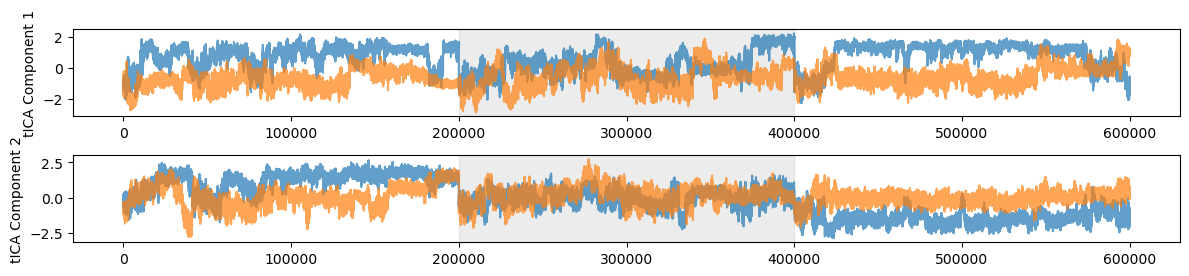

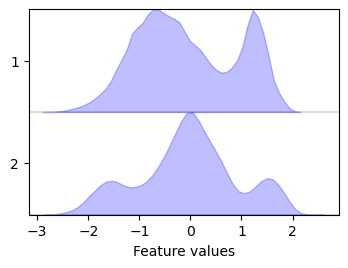

In [8]:
n_dim = 2
tica = pyemma.coordinates.tica(inter_region_distances, dim = n_dim, lag = 20)
tica_output = tica.transform(inter_region_distances)

fig, ax = plt.subplots(n_dim,1,figsize = (12,8/6*n_dim))
for i in range(n_dim):
    ax[i].plot(np.concatenate(tica_output)[0:600000,i], alpha = 0.7)
    ax[i].plot(np.concatenate(tica_output)[600000:1200000,i], alpha = 0.7)
    ax[i].axvspan(200000,400000, color = 'gray',alpha = 0.15)
    ax[i].set_ylabel("tICA Component {}".format(i+1))
#plt.axvspan(600000,800000, color = 'gray',alpha = 0.15)
#plt.axvspan(1000000,1200000, color = 'gray',alpha = 0.15)
plt.tight_layout()
fig.show()


fig, ax = plt.subplots(1,1,figsize = (4, 8/6*n_dim))
pyemma.plots.plot_feature_histograms(np.concatenate(tica_output), ax = ax, feature_labels = list(np.arange(1,n_dim+1)))

# Beyond 5 dim, the tICA components become pretty boring 
'''
fig, ax = plt.subplots(6,1,figsize = (6,7))
for i in range(6):
    
    pyemma.plots.plot_feature_histograms(tica_output[i], ax= ax[i])
    ax[i].set_title(i)'''



In [9]:
 

concat_df = pd.DataFrame(tica_output[0][0:-1:100])
concat_df['type'] = 'ADP 1'



temp = pd.DataFrame(tica_output[1][0:-1:100])
temp['type'] = 'ADP 2'

concat_df = pd.concat([concat_df,temp])

temp = pd.DataFrame(tica_output[2][0:-1:100])
temp['type'] = 'ADP 3'

concat_df = pd.concat([concat_df,temp])


temp = pd.DataFrame(tica_output[3][0:-1:100])
temp['type'] = 'dADP 1'

concat_df = pd.concat([concat_df,temp])

temp = pd.DataFrame(tica_output[4][0:-1:100])
temp['type'] = 'dADP 2'

concat_df = pd.concat([concat_df,temp])

temp = pd.DataFrame(tica_output[5][0:-1:100])
temp['type'] = 'dADP 3'

concat_df = pd.concat([concat_df,temp])

concat_df.reset_index(inplace = True, drop = True)

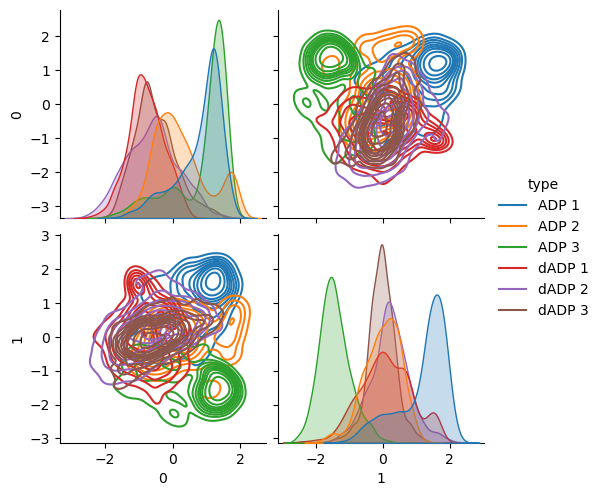

In [10]:
sns.pairplot(concat_df,kind="kde", hue = 'type')

In [13]:
len(measure_name_list)

23

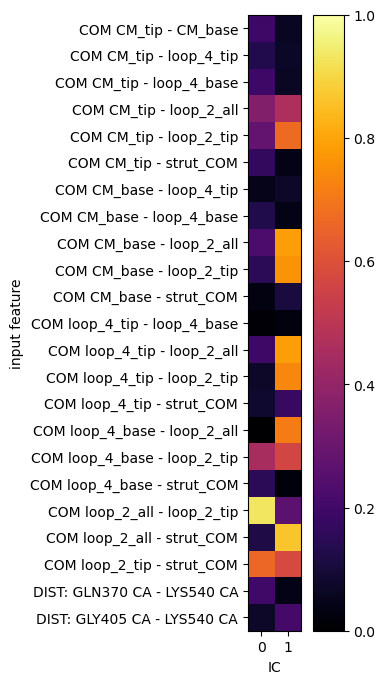

In [11]:
# tICA Feature Correlation 
fig, ax = plt.subplots(figsize=(3, 8))
i = ax.imshow(np.abs(tica.feature_TIC_correlation), cmap='inferno', vmax = 1, vmin = 0)

ax.set_xticks(range(tica.dimension()))
ax.set_xlabel('IC')

ax.set_yticks(np.arange(len(measure_name_list)))
ax.set_yticklabels(measure_name_list)
ax.set_ylabel('input feature')

fig.colorbar(i)

In [11]:
formatted_list_name = ['Dist: CM Loop tip - CM Loop base',
 'Dist: CM Loop tip - Loop 4 tip',
 'Dist: CM Loop tip - Loop 4 base',
 'Dist: CM Loop tip - Loop 2 all',
 'Dist: CM Loop tip - Loop 2 tip',
 'Dist: CM Loop tip - Strut COM',
 'Dist: CM Loop base - Loop 4 tip',
 'Dist: CM Loop base - Loop 4 base',
 'Dist: CM Loop base - Loop 2 all',
 'Dist: CM Loop base - Loop 2 tip',
 'Dist: CM Loop base - Strut COM',
 'Dist: Loop 4 tip - Loop 4 base',
 'Dist: Loop 4 tip - Loop 2 all',
 'Dist: Loop 4 tip - Loop 2 tip',
 'Dist: Loop 4 tip - Strut COM',
 'Dist: Loop 4 base - Loop 2 all',
 'Dist: Loop 4 base - Loop 2 tip',
 'Dist: Loop 4 base - Strut COM',
 'Dist: Loop 2 all - Loop 2 tip',
 'Dist: Loop 2 all - Strut COM',
 'Dist: Loop 2 tip - Strut COM',
 'Dist: GLN370 CA - LYS540 CA',
 'Dist: GLY405 CA - LYS540 CA']

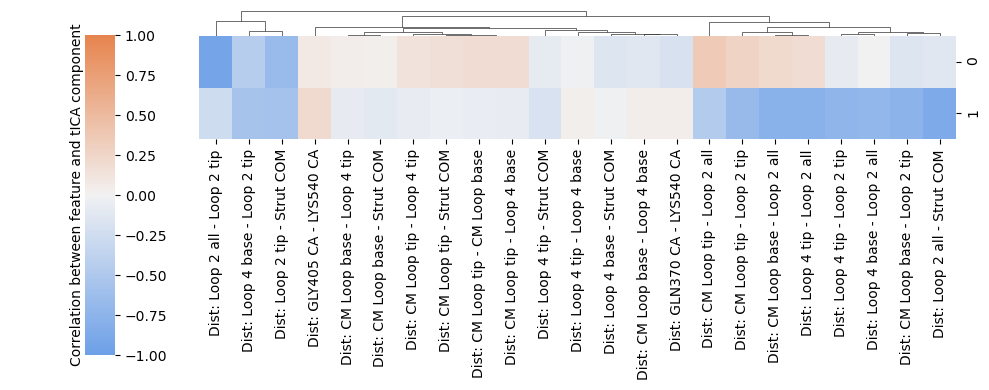

In [15]:
#help(sns.clustermap)
#fig, ax = plt.subplots(1,1,figsize = (8,3))
blue_orang_cmap = sns.diverging_palette(250, 30, l=65, center="light", as_cmap=True)

cluster_map = sns.clustermap(pd.DataFrame(np.array(tica.feature_TIC_correlation), index = formatted_list_name).T, 
               cmap=blue_orang_cmap, 
               metric = 'cityblock',
               row_cluster = False, 
               col_cluster = True, 
              vmax = 1, 
              vmin = -1, 
              figsize = (10,4), 
              cbar_pos= (0.09, 0.1, 0.03, 0.8), 
              )
plt.xlabel('tICA Component')
plt.text(-0.5, -1.05, 'Correlation between feature and tICA component', rotation=90)
plt.savefig('figures/tICA_correlation_clustermap.svg')



(-3.0, 3.0)

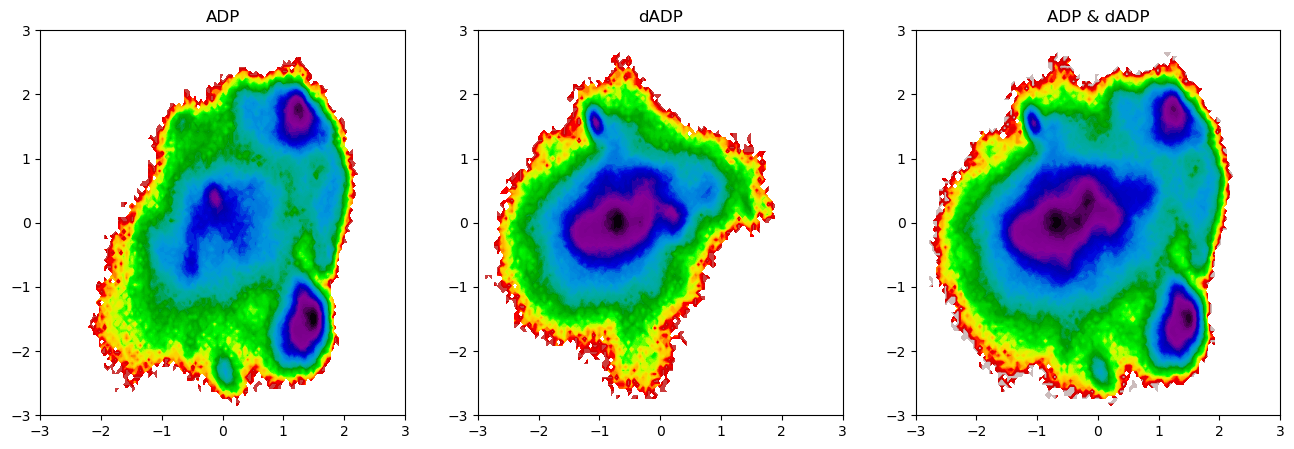

In [16]:
fig, ax = plt.subplots(1,3,figsize = (16,5))

pyemma.plots.plot_free_energy(np.concatenate(tica_output[0:3])[:,0],
    np.concatenate(tica_output[0:3])[:,1], 
    vmin = 0, 
    vmax = 7.2,
    ax = ax[0], cbar = False)

ax[0].set_title('ADP')
ax[0].set_ylim([-3,3])
ax[0].set_xlim([-3,3])

pyemma.plots.plot_free_energy(np.concatenate(tica_output[3:6])[:,0],
    np.concatenate(tica_output[3:6])[:,1], 
    vmin = 0, 
    vmax = 7.2,
    ax = ax[1], cbar = False)

ax[1].set_title('dADP')
ax[1].set_ylim([-3,3])
ax[1].set_xlim([-3,3])

pyemma.plots.plot_free_energy(np.concatenate(tica_output)[:,0],
    np.concatenate(tica_output)[:,1], 
    vmin = 0, 
    vmax = 7.2,
    ax = ax[2], cbar = False)

ax[2].set_title('ADP & dADP')
ax[2].set_ylim([-3,3])
ax[2].set_xlim([-3,3])

(<Figure size 640x480 with 2 Axes>, <AxesSubplot:>)

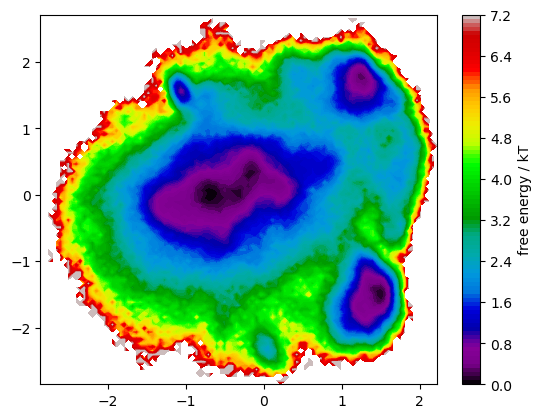

In [17]:
pyemma.plots.plot_free_energy(np.concatenate(tica_output)[:,0],
    np.concatenate(tica_output)[:,1])

### Current approach for clustering and analysis. 
- Run tICA on the super set of all the features measured distances from the trajectory 
- Select the two most prominent features from the selections (n_dim = 2)
- Select the tica output from only the ADP simulations and run k-means with k=500
- Then select the tica output from only the dADP simulations and again run k-means with k=500

In [18]:
# If using the same clustering algorithm for both state assignment run this 
run_cell = False
# Currently not running this because following approach outlined above. 
if run_cell == True: 
    combined_clustering_results = pyemma.coordinates.cluster_kmeans(tica_output, k=500, max_iter = 500, n_jobs = 24, stride = 5,
                                                                   fixed_seed = 43)

    adp_dtrajs = [combined_clustering_results.dtrajs[0],
                  combined_clustering_results.dtrajs[1],
                  combined_clustering_results.dtrajs[2]]

    dadp_dtrajs = [combined_clustering_results.dtrajs[3],
                  combined_clustering_results.dtrajs[4],
                  combined_clustering_results.dtrajs[5]]

In [12]:
# Combine the tICA output for ADP only 
adp_tica = [tica_output[0], tica_output[1],tica_output[2] ]
# Run k-means 500 clustering for ADP 
adp_clustering_results = pyemma.coordinates.cluster_kmeans(adp_tica, k=500, max_iter = 500, n_jobs = 24, stride = 1,
                                                            fixed_seed = 43)



initialize kmeans++ centers:   0%|                                      | 0/500 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                | 0/500 [00:00<?, ?it/s]

In [13]:
len(adp_clustering_results.dtrajs[0])

getting output of KmeansClustering:   0%|                                 | 0/3 [00:00<?, ?it/s]

200000

In [14]:
# Combine the tICA output for dADP only 
dadp_tica = [tica_output[3], tica_output[4],tica_output[5] ]
# Run k-means 500 clustering for dADP 
dadp_clustering_results = pyemma.coordinates.cluster_kmeans(dadp_tica, k=500, max_iter = 500, n_jobs = 24, stride = 1,  fixed_seed = 43)

initialize kmeans++ centers:   0%|                                      | 0/500 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                | 0/500 [00:00<?, ?it/s]

(-3.0, 3.0)

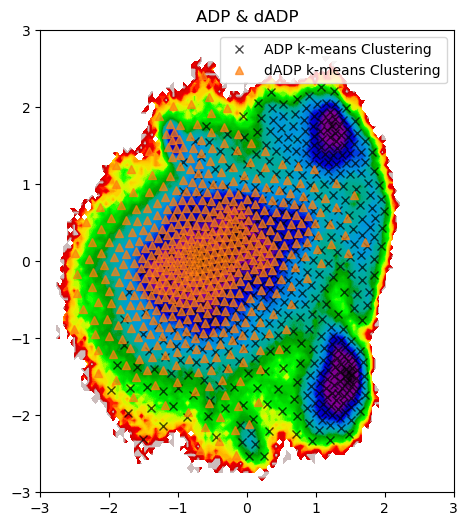

In [19]:
fig, ax = plt.subplots(1,1,figsize = (16/3,6))
pyemma.plots.plot_free_energy(np.concatenate(tica_output)[:,0],
np.concatenate(tica_output)[:,1], ax = ax, 
#cmap = 'viridis',
cbar = False)


plt.plot(*adp_clustering_results.cluster_centers_[:,0:2].T,'kx', label = 'ADP k-means Clustering', alpha = 0.7)


plt.plot(*dadp_clustering_results.cluster_centers_[:,0:2].T,'C1^', label = 'dADP k-means Clustering', alpha= 0.7)
# plt.plot(*independent_clustering_results.cluster_centers_[:,0:2].T,'.', label = 'ADP + dADP')
#
plt.legend() # loc = (1.2, 0.4))
#plt.tight_layout()
#ax.set_xlabel('tICA 1')
#ax.set_ylabel('tICA 2')
plt.title('ADP & dADP')
plt.xlim([-3,3])
plt.ylim([-3,3])

#plt.savefig('2-D tICA Free Energy.png')

In [20]:
# Use the clustering results from the dataset of ADP only 
independent_its_adp = pyemma.msm.timescales_msm(adp_clustering_results.dtrajs, lags=150, nits=15, n_jobs=24, errors='bayes') #errors='bayes'1


estimating BayesianMSM:   0%|                                            | 0/13 [00:00<?, ?it/s]

In [21]:
# Use the clustering results from having only dADP 
independent_its_dadp = pyemma.msm.timescales_msm(dadp_clustering_results.dtrajs, lags=150, nits=15, n_jobs=24, errors='bayes') #errors='bayes'1


getting output of KmeansClustering:   0%|                                 | 0/3 [00:00<?, ?it/s]

estimating BayesianMSM:   0%|                                            | 0/13 [00:00<?, ?it/s]

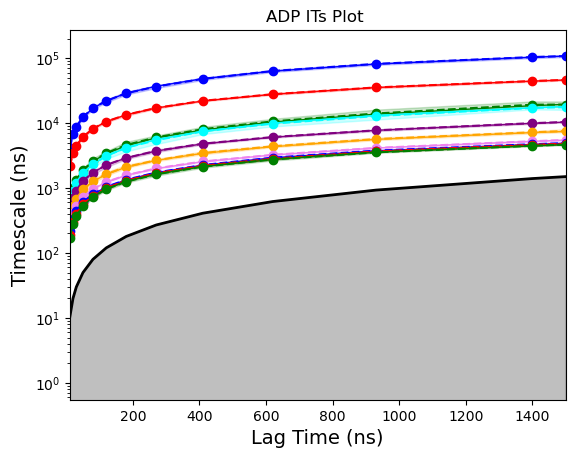

In [67]:
pyemma.plots.plot_implied_timescales(independent_its_adp, units='ps', dt = 10, linewidth=1, nits = 10) #units can be ns if desired
plt.title('ADP ITs Plot ')
plt.xlabel('Lag Time (ns)', fontsize=14)
plt.ylabel('Timescale (ns)', fontsize=14)

plt.ylim(0.5512674027338345, 270017.20166412793)
plt.savefig('figures/ADP_ITs_Plots.svg')

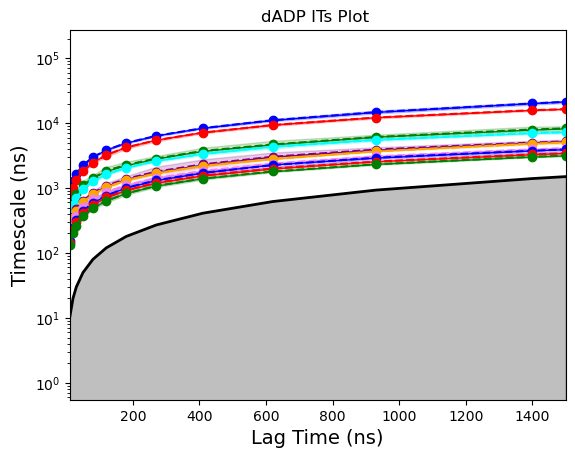

In [68]:
pyemma.plots.plot_implied_timescales(independent_its_dadp, units='ps', dt = 10, linewidth=1, nits = 10) #units can be ns if desired
plt.title('dADP ITs Plot ')
plt.xlabel('Lag Time (ns)', fontsize=14)
plt.ylabel('Timescale (ns)', fontsize=14)
plt.ylim(0.5512674027338345, 270017.20166412793)
plt.savefig('figures/dADP_ITs_Plots.svg')

In [26]:
'''combined_its_adp = pyemma.msm.timescales_msm(dadp_dtrajs, lags=150, nits=15, n_jobs=24, errors='bayes') #errors='bayes'1
pyemma.plots.plot_implied_timescales(combined_its_adp, units='steps', linewidth=1) #units can be ns if desired
plt.title('k = 500 Implied Timescale Plot with Errors dADP Combined Cluster')
plt.xlabel('Lag Time (steps)', fontsize=24)
plt.ylabel('Timescale (steps)', fontsize=24)
'''

"combined_its_adp = pyemma.msm.timescales_msm(dadp_dtrajs, lags=150, nits=15, n_jobs=24, errors='bayes') #errors='bayes'1\npyemma.plots.plot_implied_timescales(combined_its_adp, units='steps', linewidth=1) #units can be ns if desired\nplt.title('k = 500 Implied Timescale Plot with Errors dADP Combined Cluster')\nplt.xlabel('Lag Time (steps)', fontsize=24)\nplt.ylabel('Timescale (steps)', fontsize=24)\n"

#### Attempt to load previously created model

In [46]:
help(pyemma.msm.bayesian_markov_model)

Help on function bayesian_markov_model in module pyemma.msm.api:

bayesian_markov_model(dtrajs, lag, reversible=True, statdist=None, sparse=False, connectivity='largest', count_mode='effective', nsamples=100, conf=0.95, dt_traj='1 step', show_progress=True, mincount_connectivity='1/n', core_set=None, milestoning_method='last_core')
    Bayesian Markov model estimate using Gibbs sampling of the posterior
    
    Returns a :class:`BayesianMSM` that contains the
    estimated transition matrix and allows to compute a large number of
    quantities related to Markov models as well as their statistical
    uncertainties.
    
    Parameters
    ----------
    dtrajs : list containing ndarrays(dtype=int) or ndarray(n, dtype=int)
        discrete trajectories, stored as integer ndarrays (arbitrary size)
        or a single ndarray for only one trajectory.
    lag : int
        lagtime for the MSM estimation in multiples of trajectory steps
    reversible : bool, optional, default = True
    

In [46]:
n_metastable = 3

if input("Do you want to load a model? (type 'load')") == 'load':
    print("Attempting to load model")
    adp_msm = pyemma.load('msm_datafiles/stride_1_adp_msm_070124.h5')
    ck_adp = pyemma.load('msm_datafiles/stride_1_ck_adp_070124.h5')
    
    dadp_msm = pyemma.load('msm_datafiles/stride_1_dadp_msm_070124.h5')
    ck_dadp = pyemma.load('msm_datafiles/stride_1_ck_dadp_070124.h5')
    print("Models loaded successfully")

else: 
    do_model = input("Preparing to re-calculated MSM models and CK tests, this is slow. Are you sure? (Enter 'run'): ")    
    if do_model == 'run':
        print("Running model calculation")
        adp_msm = pyemma.msm.bayesian_markov_model(adp_clustering_results.dtrajs, 90, reversible=True, dt_traj = '10 ps')

        ck_adp = adp_msm.cktest(n_metastable, memberships=None, conf=0.95, err_est=True, n_jobs=24, show_progress=True)

        adp_msm.save('msm_datafiles/stride_1_adp_msm_070124.h5', overwrite = True)

        ck_adp.save('msm_datafiles/stride_1_ck_adp_070124.h5', overwrite = True)

        dadp_msm = pyemma.msm.bayesian_markov_model(dadp_clustering_results.dtrajs, 90, reversible=True, dt_traj = '10 ps')

        ck_dadp = dadp_msm.cktest(n_metastable, memberships=None, conf=0.95, err_est=True, n_jobs=24, show_progress=True)

        dadp_msm.save('msm_datafiles/stride_1_dadp_msm_070124.h5', overwrite = True)

        ck_dadp.save('msm_datafiles/stride_1_ck_dadp_070124.h5', overwrite = True)



Do you want to load a model? (type 'load')no
Preparing to re-calculated MSM models and CK tests, this is slow. Are you sure? (Enter 'run'): run
Running model calculation


pyemma.msm.estimators.bayesian_msm.BayesianMSM[7]: compute stat. inefficiencies:   0%| | 0/42484

pyemma.msm.estimators.bayesian_msm.BayesianMSM[7]: Sampling MSMs:   0%| | 0/100 [00:00<?, ?it/s]

estimating BayesianMSM:   0%|                                             | 0/9 [00:00<?, ?it/s]

getting output of KmeansClustering:   0%|                                 | 0/3 [00:00<?, ?it/s]

pyemma.msm.estimators.bayesian_msm.BayesianMSM[9]: compute stat. inefficiencies:   0%| | 0/66205

pyemma.msm.estimators.bayesian_msm.BayesianMSM[9]: Sampling MSMs:   0%| | 0/100 [00:00<?, ?it/s]

estimating BayesianMSM:   0%|                                             | 0/9 [00:00<?, ?it/s]

In [66]:
ck_adp.memberships[5]

array([0.17809981, 0.72460542, 0.09729477])

Text(0.5, 1.0, 'ADP Transition Matrix')

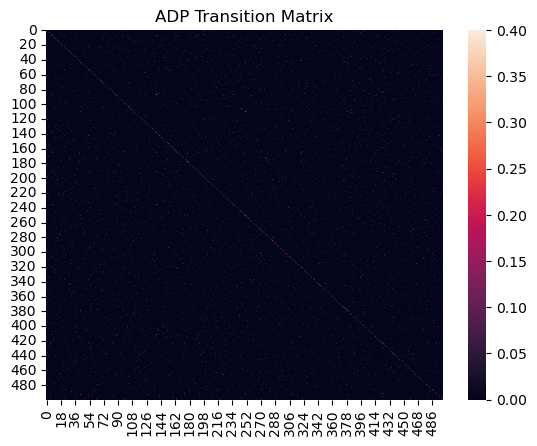

In [28]:
sns.heatmap(adp_msm.transition_matrix, vmin = 0, vmax = 0.4)
plt.title('ADP Transition Matrix')


Text(0.5, 1.0, 'dADP Transition Matrix')

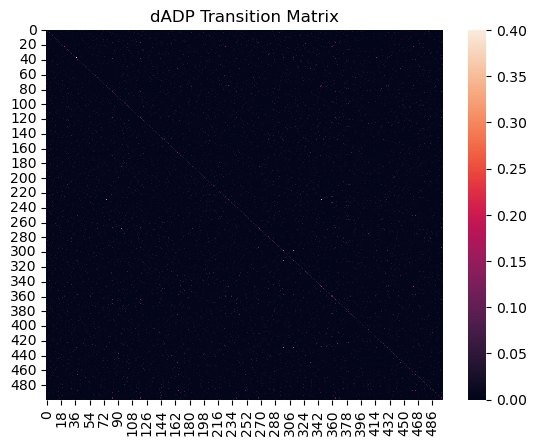

In [29]:
sns.heatmap(dadp_msm.transition_matrix, vmin = 0, vmax = 0.4)
plt.title('dADP Transition Matrix')

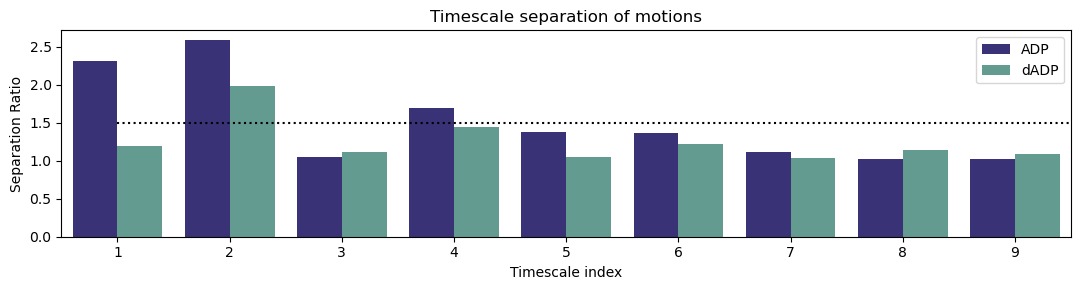

In [47]:
plt.figure(figsize = (10.91,3))
plt.bar(np.arange(9)-0.2,
        adp_msm.timescales()[0:10-1]/adp_msm.timescales()[1:10], width= 0.4, 
       align = 'center', 
       color = '#393276',
        label = 'ADP')

plt.bar(np.arange(9)+0.2,
        dadp_msm.timescales()[0:10-1]/dadp_msm.timescales()[1:10], width= 0.4, 
       align = 'center', 
       color = '#639B90', 
       label = 'dADP')

plt.plot(np.full(len(adp_msm.timescales()[:-1]/adp_msm.timescales()[1:]), 1.5), ':k')
plt.xlabel('Timescale index'); 
plt.ylabel('Separation Ratio')
plt.xlim(-0.5,8.5)
plt.title('Timescale separation of motions')

plt.xticks(np.arange(9), np.arange(9)+1)
plt.legend()
plt.tight_layout()
plt.savefig('figures/timescale_separation.svg')

In [75]:
help(dadp_msm.cktest)

Help on method cktest in module pyemma.msm.estimators._msm_estimator_base:

cktest(nsets, memberships=None, mlags=10, conf=0.95, err_est=False, n_jobs=None, show_progress=True) method of pyemma.msm.estimators.bayesian_msm.BayesianMSM instance
    Conducts a Chapman-Kolmogorow test.
    
    Parameters
    ----------
    nsets : int
        number of sets to test on
    memberships : ndarray(nstates, nsets), optional
        optional state memberships. By default (None) will conduct a cktest
        on PCCA (metastable) sets.
    mlags : int or int-array, optional
        multiples of lag times for testing the Model, e.g. range(10).
        A single int will trigger a range, i.e. mlags=10 maps to
        mlags=range(10). The setting None will choose mlags automatically
        according to the longest available trajectory
    conf : float, optional
        confidence interval
    err_est : bool, optional
        compute errors also for all estimations (computationally expensive)
       

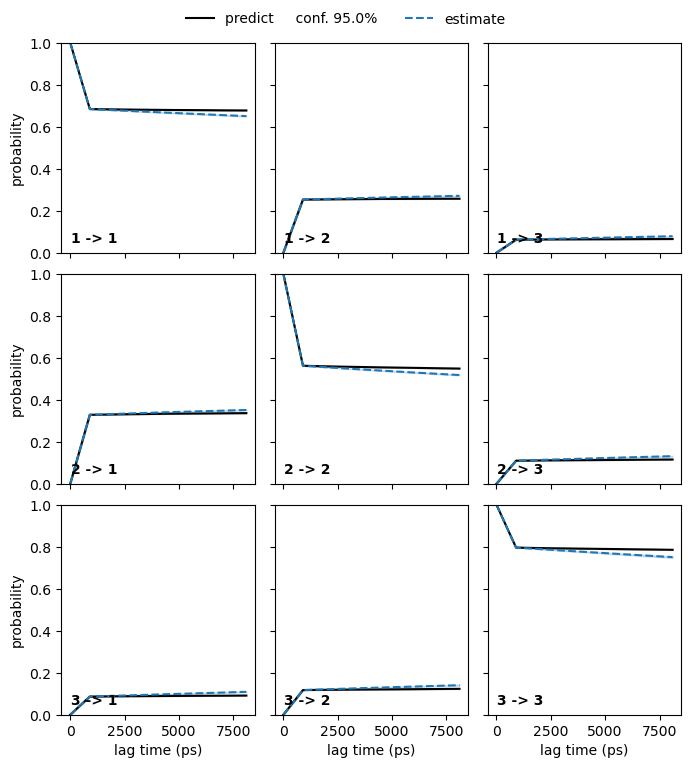

In [48]:
pyemma.plots.plot_cktest(ck_adp, diag=False, figsize=(8,8), padding_top=0.05, y01=True, padding_between=0.1, dt=10, units='ps')
plt.savefig('figures/CK_test_adp.svg')

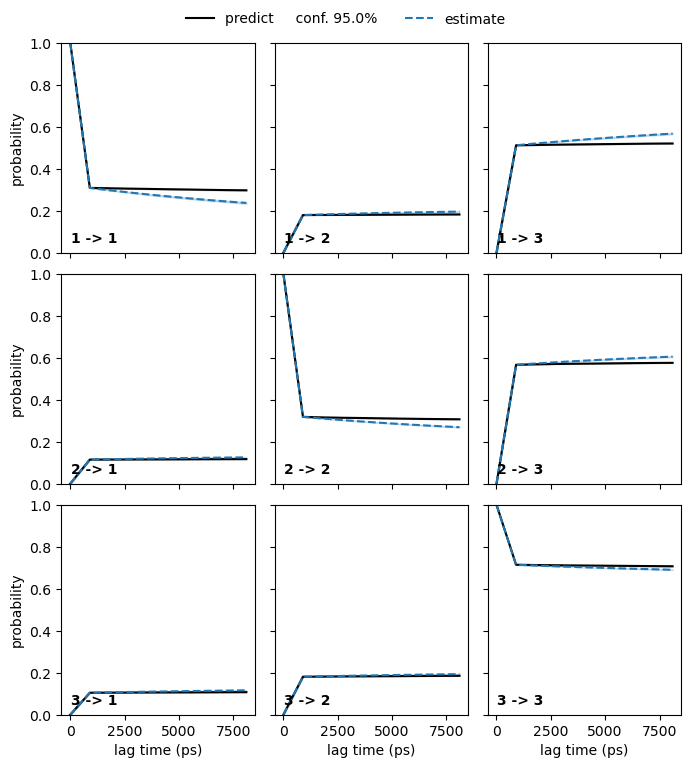

In [49]:
pyemma.plots.plot_cktest(ck_dadp, diag=False, figsize=(8,8), padding_top=0.05, y01=True, padding_between=0.1, dt=10, units='ps')
plt.savefig('figures/CK_test_dadp.svg')

### Contour Plot

In [50]:
adp_full_traj = np.concatenate(adp_msm.dtrajs_full)
dadp_full_traj = np.concatenate(dadp_msm.dtrajs_full)


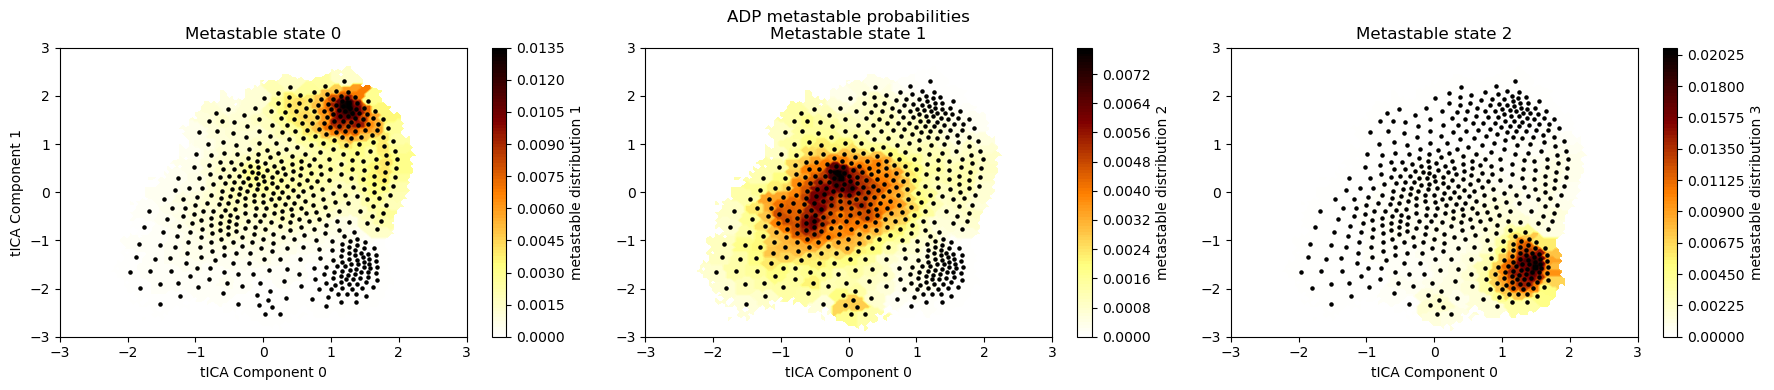

In [71]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

data = np.concatenate(adp_tica)

for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *data.T, adp_msm.metastable_distributions[i][adp_full_traj], ax=ax, cmap='afmhot_r',
        mask=True, method='nearest', cbar_label='metastable distribution {}'.format(i + 1))
    ax.scatter(*adp_clustering_results.cluster_centers_[:,0:2].T, s=5, c='k')
    ax.set_xlabel('tICA Component 0')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    #ax.set_aspect('equal')
axes[0].set_ylabel('tICA Component 1')
axes[1].set_title('ADP metastable probabilities\nMetastable state 1')
axes[0].set_title('Metastable state 0')
axes[2].set_title('Metastable state 2')
fig.tight_layout()

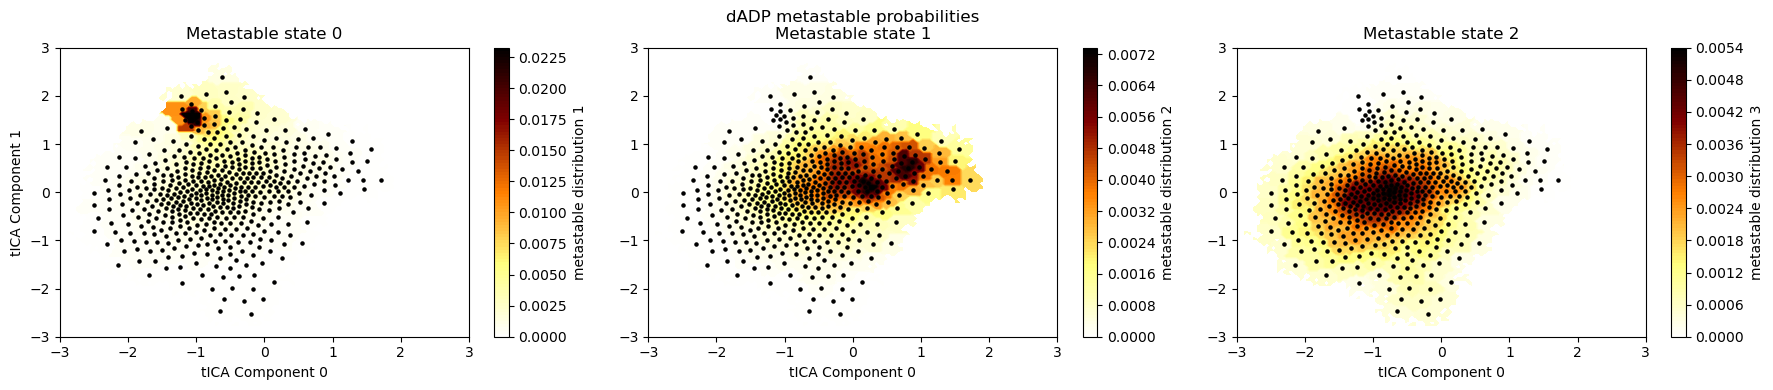

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

data = np.concatenate(dadp_tica)

for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *data.T, dadp_msm.metastable_distributions[i][dadp_full_traj], ax=ax, cmap='afmhot_r',
        mask=True, method='nearest', cbar_label='metastable distribution {}'.format(i + 1))
    ax.scatter(*dadp_clustering_results.cluster_centers_[:,0:2].T, s=5, c='k')
    ax.set_xlabel('tICA Component 0')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    #ax.set_aspect('equal')
axes[0].set_ylabel('tICA Component 1')
axes[1].set_title('dADP metastable probabilities\nMetastable state 1')
axes[0].set_title('Metastable state 0')
axes[2].set_title('Metastable state 2')
fig.tight_layout()

### Network Visualization 

In [53]:
# ADP Distributions description 
# n_cols = 3 (n_metastable, not trajs)
# r_rows = number of initial cluster states 
# Sum of the row = 1 
# This is the probability that a metastable conformation visits the particular k-means state
# 

def get_highest_memberships(markov_state_model, n_metastable):
    dists = markov_state_model.metastable_distributions
    assignments = markov_state_model.metastable_assignments
    highest = np.zeros(n_metastable, dtype = int)
    # Loop through metastable confs 
    for i in range(n_metastable):
        # Sorted from largest to smallest 
        sorted = dists[i].argsort()[::-1] 
        # Ensure it's actually assigned to the correct metastable state 
        within_state = assignments[sorted] == i
        highest[i] = sorted[within_state][0]
    return highest 



In [54]:
# help(adp_msm.metastable_distributions)

adp_metastable_traj = adp_msm.metastable_assignments[adp_full_traj]


highest_membership_adp = get_highest_memberships(adp_msm, n_metastable= n_metastable)

adp_coarse_state_centers = adp_clustering_results.clustercenters[highest_membership_adp]





In [55]:
# help(dadp_msm.metastable_distributions)

dadp_metastable_traj = dadp_msm.metastable_assignments[dadp_full_traj]


highest_membership_dadp = get_highest_memberships(dadp_msm, n_metastable= n_metastable)

dadp_coarse_state_centers = dadp_clustering_results.clustercenters[highest_membership_dadp]

In [56]:
from tqdm import tqdm

In [57]:
adp_msm.mfpt(
            adp_msm.metastable_sets[0],
            adp_msm.metastable_sets[1])/1000

52.389718191540894

In [58]:
nstates = 3

adp_mfpt = np.zeros((nstates, nstates))
for i in tqdm(range(nstates)):
    for j in range(nstates):
        adp_mfpt[i, j] = adp_msm.mfpt(
            adp_msm.metastable_sets[i],
            adp_msm.metastable_sets[j])

adp_inverse_mfpt = np.zeros_like(adp_mfpt)
adp_nz = adp_mfpt.nonzero()
adp_inverse_mfpt[adp_nz] = 1.0 / adp_mfpt[adp_nz]

100%|█████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 83.77it/s]


In [59]:
nstates = 3

dadp_mfpt = np.zeros((nstates, nstates))
for i in tqdm(range(nstates)):
    for j in range(nstates):
        dadp_mfpt[i, j] = dadp_msm.mfpt(
            dadp_msm.metastable_sets[i],
            dadp_msm.metastable_sets[j])

dadp_inverse_mfpt = np.zeros_like(dadp_mfpt)
dadp_nz = dadp_mfpt.nonzero()
dadp_inverse_mfpt[dadp_nz] = 1.0 / dadp_mfpt[dadp_nz]

100%|█████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.11it/s]


In [60]:
adp_stable_counts= np.zeros(3)

for i in range(3):
    adp_stable_counts[i] = np.sum(adp_metastable_traj==i)
    
adp_stable_counts /= len(adp_stable_counts)


In [61]:
dadp_stable_counts= np.zeros(3)

for i in range(3):
    dadp_stable_counts[i] = np.sum(dadp_metastable_traj==i)
    
dadp_stable_counts /= len(dadp_stable_counts)


In [62]:
# Definite plotting colors 

from matplotlib.colors import ListedColormap

# List of hex colors

# List of HEX colors for ADP 
ADP_colors = ['#8063FF', '#332288', '#281E50']

# List of HEX colors for dADP 
dADP_colors = ['#58E9D3', '#44AA99', '#22564E']

# Create a ListedColormap
adp_custom_cmap = ListedColormap(ADP_colors)

dadp_custom_cmap = ListedColormap(dADP_colors)




In [189]:
adp_state_df = pd.DataFrame(np.concatenate(adp_tica), columns = ['tic_0','tic_1'])
adp_state_df['state'] = adp_metastable_traj


In [186]:
dadp_state_df = pd.DataFrame(np.concatenate(dadp_tica), columns = ['tic_0','tic_1'])
dadp_state_df['state'] = dadp_metastable_traj

<AxesSubplot:xlabel='tic_0', ylabel='tic_1'>

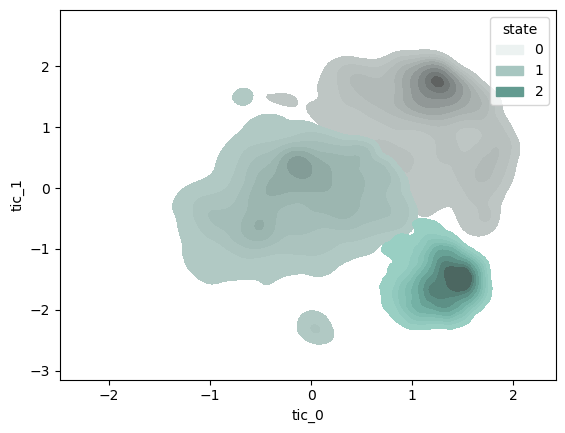

(-3.0, 3.0)

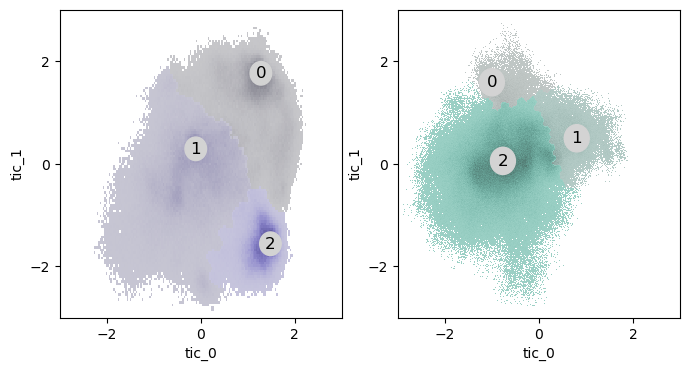

In [209]:
fig, ax = plt.subplots(1,2,figsize=(8, 4))


sns.histplot(data = adp_state_df, x = 'tic_0',y = 'tic_1', hue = 'state',
            fill = True,
            palette= sns.light_palette("#393276", as_cmap=True),
           #common_grid = True,
           # common_norm = True,
            ax = ax[0],
            legend = False
           )

pyemma.plots.plot_network(
    adp_inverse_mfpt,
    pos=adp_coarse_state_centers,
    figpadding=0,
    #arrow_label_format='%.0f ps',
    arrow_label_format='',
    #state_sizes = np.array([0.1,5,10]),
    arrow_labels=adp_mfpt,
    size=12,
    show_frame=True,
    state_colors = '#D3D3D3',
    ax=ax[0])

ax[0].set_xticks([-2,0,2])
ax[0].set_yticks([-2,0,2])

ax[0].set_xlim(-3, 3)
ax[0].set_ylim(-3, 3)

sns.histplot(data = dadp_state_df, x = 'tic_0',y = 'tic_1', hue = 'state',
            fill = True,
            palette= sns.light_palette("#639B90", as_cmap=True),
           #common_grid = True,
           # common_norm = True,
            ax = ax[1],
            legend = False
           )


pyemma.plots.plot_network(
    dadp_inverse_mfpt,
    pos=dadp_coarse_state_centers,
    #figpadding=0,
    #arrow_label_format='%.0f ps',
    arrow_label_format='',
    #state_sizes = np.array([0.1,5,10]),
    arrow_labels=dadp_mfpt,
    size=12,
    show_frame=True,
    state_colors = '#D3D3D3',
    arrow_scale = 1.3,
    arrow_curvature = 2,
    ax=ax[1])

sns.histplot(data = dadp_state_df, x = 'tic_0',y = 'tic_1', hue = 'state',
            fill = True,
            palette= sns.light_palette("#639B90", as_cmap=True),
           #common_grid = True,
           # common_norm = True,
            ax = ax[1],
            legend = False,
           zorder = float('-inf'))



ax[1].set_xticks([-2,0,2])
ax[1].set_yticks([-2,0,2])

ax[1].set_xlim(-3, 3)
ax[1].set_ylim(-3, 3)

# plt.savefig('figures/adp_and_dadp_contour_statemap_network.svg')

In [210]:
def _draw_arrow(
        x1, y1, x2, y2, Dx, Dy, label="", width=1.0, arrow_curvature=1.0, color="grey",
        patchA=None, patchB=None, shrinkA=0, shrinkB=0, arrow_label_size=None):
        """
        Draws a slightly curved arrow from (x1,y1) to (x2,y2).
        Will allow the given patches at start end end.

        """
        # set arrow properties
        dist = _sqrt(
            ((x2 - x1) / float(Dx))**2 + ((y2 - y1) / float(Dy))**2)
        arrow_curvature *= 0.075  # standard scale
        rad = arrow_curvature / (dist)
        tail_width = width
        head_width = max(0.5, 2 * width)
        head_length = head_width
        
        
        # weighted center position
        center = _np.array([0.55 * x1 + 0.45 * x2, 0.55 * y1 + 0.45 * y2])
        v = _np.array([x2 - x1, y2 - y1])  # 1->2 vector
        vabs = _np.abs(v)
        vnorm = _np.array([v[1], -v[0]])  # orthogonal vector
        vnorm = _np.divide(vnorm, _np.linalg.norm(vnorm))  # normalize
        # cross product to determine the direction into which vnorm points
        z = _np.cross(v, vnorm)
        if z < 0:
            vnorm *= -1
        offset = 0.5 * arrow_curvature * \
            ((vabs[0] / (vabs[0] + vabs[1]))
             * Dx + (vabs[1] / (vabs[0] + vabs[1])) * Dy)
        ptext = center + offset * vnorm
        


In [ ]:
fig, ax = plt.subplots(1,1)



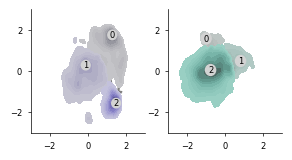

In [255]:
fig, ax = plt.subplots(1,2,figsize=(3.25, 1.6))


sns.kdeplot(data = adp_state_df, x = 'tic_0',y = 'tic_1', hue = 'state',
            fill = True,
            palette= sns.light_palette("#393276", as_cmap=True),
           common_grid = True,
            common_norm = True,
            ax = ax[0],
            legend = False
           )

pyemma.plots.plot_network(
    adp_inverse_mfpt,
    pos=adp_coarse_state_centers,
    figpadding=0,
    #arrow_label_format='%.0f ps',
    arrow_label_format='',
    #state_sizes = np.array([0.1,5,10]),
    arrow_labels=adp_mfpt,
    size=12/2,
    show_frame=True,
    state_colors = '#D3D3D3',
    arrow_scale = 1.3/3,
    arrow_curvature = 2,
    ax=ax[0])

ax[0].set_xticks([-2,0,2])
ax[0].set_yticks([-2,0,2])

ax[0].set_xlim(-3, 3)
ax[0].set_ylim(-3, 3)

sns.kdeplot(data = dadp_state_df, x = 'tic_0',y = 'tic_1', hue = 'state',
            fill = True,
            palette= sns.light_palette("#639B90", as_cmap=True),
           common_grid = True,
            common_norm = True,
            ax = ax[1],
            legend = False
           )


pyemma.plots.plot_network(
    dadp_inverse_mfpt,
    pos=dadp_coarse_state_centers,
    #figpadding=0,
    #arrow_label_format='%.0f ps',
    arrow_label_format='',
    #state_sizes = np.array([0.1,5,10]),
    arrow_labels=dadp_mfpt,
    size=12/2,
    show_frame=True,
    state_colors = '#D3D3D3',
    arrow_scale = 1.3/3,
    arrow_curvature = 2,
    ax=ax[1])

ax[1].set_xticks([-2,0,2])
ax[1].set_yticks([-2,0,2])

ax[1].set_xlim(-3, 3)
ax[1].set_ylim(-3, 3)

# Set the tick parameters
for i in range(2):
    ax[i].tick_params(width=0.5, length = 2.5)

    # Set the linewidth for the spines
    for spine in ax[i].spines.values():
        spine.set_linewidth(0.5)

    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    plt.sca(ax[i])
    plt.xticks(fontsize = 6)
    plt.yticks(fontsize = 6)
    '''left, bottom, width, height = ax[i].get_position().bounds
    print(ax[i].get_position().bounds)
    width = 1.116  # Convert inches to figure relative width
    height = 1.116  # Convert inches to figure relative height
    '''
    #ax[i].set_position([left, bottom, width, height])

plt.savefig('figures/adp_and_dadp_contour_statemap_network.svg')

In [211]:
import deeptime

In [215]:
deeptime.__version__

'0.4.2'

(-3.0, 3.0)

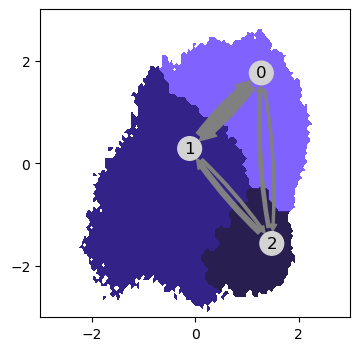

In [63]:
#fig, ax = plt.subplots(figsize=(10, 7))
fig, ax = plt.subplots(figsize = (4,4))
_, _, misc = pyemma.plots.plot_state_map(
    *np.concatenate(adp_tica).T, adp_metastable_traj, ax=ax, zorder=-1, cmap = adp_custom_cmap, cbar = False)
# misc['cbar'].set_ticklabels(range(0, nstates + 0))  # set state numbers 1 ... nstates

pyemma.plots.plot_network(
    adp_inverse_mfpt,
    pos=adp_coarse_state_centers,
    figpadding=0,
    #arrow_label_format='%.0f ps',
    arrow_label_format='',
    #state_sizes = np.array([0.1,5,10]),
    arrow_labels=adp_mfpt,
    size=12,
    show_frame=True,
    state_colors = '#D3D3D3',
    ax=ax)

ax.set_xticks([-2,0,2])
ax.set_yticks([-2,0,2])

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
# plt.tight_layout()
#plt.savefig('figures/adp_statemap_network.svg')

(-3.0, 3.0)

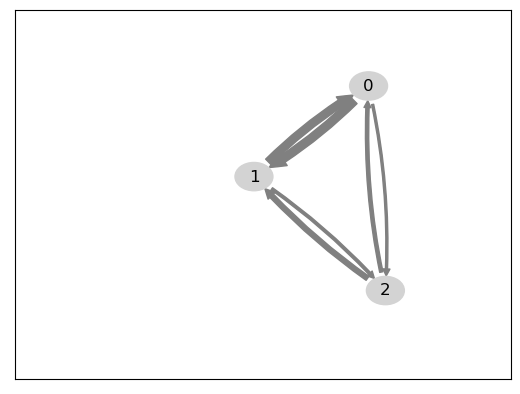

In [64]:
fig, ax = plt.subplots()


pyemma.plots.plot_network(
    adp_inverse_mfpt,
    pos=adp_coarse_state_centers,
    figpadding=0,
    #arrow_label_format='%.0f ps',
    arrow_label_format='',
    #state_sizes = np.array([0.1,5,10]),
    arrow_labels=adp_mfpt,
    size=12,
    show_frame=True,
    state_colors = '#D3D3D3',
    ax=ax)

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

(-3.0, 3.0)

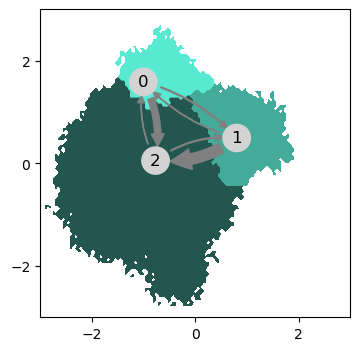

In [65]:
fig, ax = plt.subplots(figsize=(4, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *np.concatenate(dadp_tica).T, dadp_metastable_traj, ax=ax, zorder=-1, cbar = False, cmap = dadp_custom_cmap)
# misc['cbar'].set_ticklabels(range(0, nstates + 0))  # set state numbers 1 ... nstates

pyemma.plots.plot_network(
    dadp_inverse_mfpt,
    pos=dadp_coarse_state_centers,
    #figpadding=0,
    #arrow_label_format='%.0f ps',
    arrow_label_format='',
    #state_sizes = np.array([0.1,5,10]),
    arrow_labels=dadp_mfpt,
    size=12,
    show_frame=True,
    state_colors = '#D3D3D3',
    arrow_scale = 1.3,
    arrow_curvature = 2,
    ax=ax)

ax.set_xticks([-2,0,2])
ax.set_yticks([-2,0,2])

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
# plt.tight_layout()
# plt.savefig('figures/dadp_statemap_network.svg')

(-3.0, 3.0)

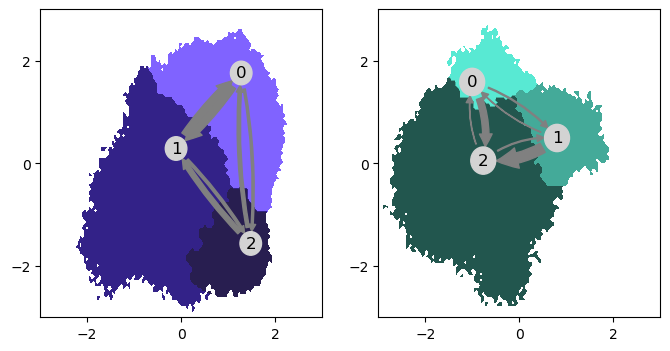

In [66]:
fig, ax = plt.subplots(1,2,figsize=(8, 4))

## Plot ADP state map
_, _, misc = pyemma.plots.plot_state_map(
    *np.concatenate(adp_tica).T, adp_metastable_traj, ax=ax[0], zorder=-1, cmap = adp_custom_cmap, cbar = False)
# misc['cbar'].set_ticklabels(range(0, nstates + 0))  # set state numbers 1 ... nstates

pyemma.plots.plot_network(
    adp_inverse_mfpt,
    pos=adp_coarse_state_centers,
    figpadding=0,
    #arrow_label_format='%.0f ps',
    arrow_label_format='',
    #state_sizes = np.array([0.1,5,10]),
    arrow_labels=adp_mfpt,
    size=12,
    show_frame=True,
    state_colors = '#D3D3D3',
    ax=ax[0])

ax[0].set_xticks([-2,0,2])
ax[0].set_yticks([-2,0,2])

ax[0].set_xlim(-3, 3)
ax[0].set_ylim(-3, 3)

## Plot dADP state map
_, _, misc = pyemma.plots.plot_state_map(
    *np.concatenate(dadp_tica).T, dadp_metastable_traj, ax=ax[1], zorder=-1, cbar = False, cmap = dadp_custom_cmap)
# misc['cbar'].set_ticklabels(range(0, nstates + 0))  # set state numbers 1 ... nstates

pyemma.plots.plot_network(
    dadp_inverse_mfpt,
    pos=dadp_coarse_state_centers,
    #figpadding=0,
    #arrow_label_format='%.0f ps',
    arrow_label_format='',
    #state_sizes = np.array([0.1,5,10]),
    arrow_labels=dadp_mfpt,
    size=12,
    show_frame=True,
    state_colors = '#D3D3D3',
    arrow_scale = 1.3,
    arrow_curvature = 2,
    ax=ax[1])

ax[1].set_xticks([-2,0,2])
ax[1].set_yticks([-2,0,2])

ax[1].set_xlim(-3, 3)
ax[1].set_ylim(-3, 3)
# plt.tight_layout()
# plt.savefig('figures/adp_and_dadp_statemap_network.svg')

(-3.141592653589793, 3.141592653589793)

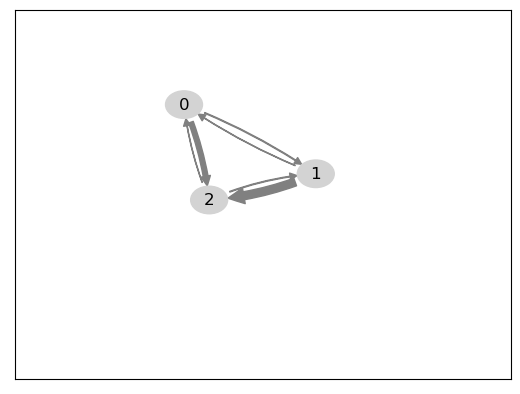

In [48]:
fig, ax = plt.subplots()


pyemma.plots.plot_network(
    dadp_inverse_mfpt,
    pos=dadp_coarse_state_centers,
    figpadding=0,
    #arrow_label_format='%.0f ps',
    arrow_label_format='',
    #state_sizes = np.array([0.1,5,10]),
    arrow_labels=dadp_mfpt,
    size=12,
    show_frame=True,
    state_colors = '#D3D3D3',
    ax=ax)

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

/tmp/ipykernel_1027735/1995780222.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


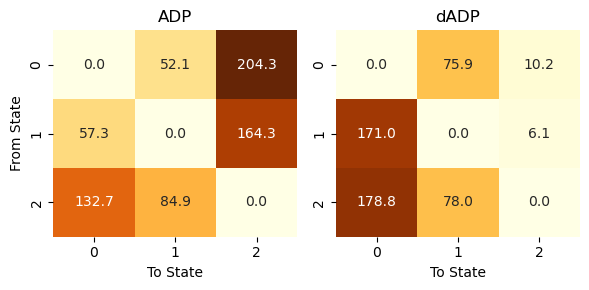

In [117]:
fig, ax = plt.subplots(1,2,figsize = (6,3))

sns.heatmap(adp_mfpt/1000, ax = ax[0], 
            cbar = False, 
            vmin = 0,
            vmax = 200,
            annot= True, 
            cmap = 'YlOrBr',fmt=".1f")

sns.heatmap(dadp_mfpt/1000, ax = ax[1], 
            cbar = False,
            vmin = 0, 
            vmax = 200,
            annot= True,
            cmap = 'YlOrBr',fmt=".1f")
ax[0].set_ylabel('From State') 
ax[0].set_xlabel('To State')
ax[1].set_xlabel('To State')

ax[0].set_title('ADP')
ax[1].set_title('dADP')
#fig.text(0.5,1.0,'Mean first Passage Time (ns)', ha = 'center', fontsize = 14)
plt.tight_layout()
fig.show()
plt.savefig('figures/mean_first_passage_times.svg')

In [61]:

adp_samples_file = "msm_datafiles/adp_sampled_frame_data.pkl"

try:
    f = open(adp_samples_file, 'rb')
    adp_samples = pickle.load(f)
    f.close()
    print("Loading samples from {}".format(adp_samples_file))
    print("Modified on:")
    modified = os.path.getctime(adp_samples_file)
    print(datetime.datetime.fromtimestamp(modified))
except:
    print("Unable to load file. ")
    print("Sampling from MSM. ")
    adp_samples = adp_msm.sample_by_distributions(adp_msm.metastable_distributions,15)
    f = open(adp_samples_file,'wb')
    pickle.dump(adp_samples, f)
    f.close()
    print('Saved to {}'.format(adp_samples_file))

Loading samples from msm_datafiles/adp_sampled_frame_data.pkl
Modified on:
2023-10-09 14:01:46.617136


In [67]:

dadp_samples_file = "msm_datafiles/dadp_sampled_frame_data.pkl"

try:
    f = open(dadp_samples_file, 'rb')
    dadp_samples = pickle.load(f)
    f.close()
    print("Loading samples from {}".format(dadp_samples_file))
    print("Modified on:")
    modified = os.path.getctime(dadp_samples_file)
    print(datetime.datetime.fromtimestamp(modified))
except:
    print("Unable to load file. ")
    print("Sampling from MSM. ")
    dadp_samples = dadp_msm.sample_by_distributions(dadp_msm.metastable_distributions,15)
    f = open(dadp_samples_file,'wb')
    pickle.dump(dadp_samples, f)
    f.close()
    print('Saved to {}'.format(dadp_samples_file))

Loading samples from msm_datafiles/dadp_sampled_frame_data.pkl
Modified on:
2023-10-09 14:01:50.409218


In [63]:
# adp_samples = adp_msm.sample_by_distributions(adp_msm.metastable_distributions,15)

traj_list = []

for k in range(3):
    print(k)
    for traj_n, frame_n in adp_samples[k]:
        #f traj_n == k:
        print("{}-{}".format(traj_n,frame_n), end = ' ')
        traj_list.append(md.load_frame('/media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_adp_{}_2us_10ps.nc'.format(traj_n+1),
             top = '/media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_adp_strip.prmtop',
             index = frame_n))
    print()

0
0-73988 0-132618 0-16675 2-22620 1-114782 0-152143 0-16257 0-176635 1-190028 0-100863 0-119521 0-108877 0-173588 0-60192 1-83665 
1
1-122180 2-22200 1-178320 1-143122 2-196368 1-4405 0-50171 0-187340 1-115466 2-1438 0-184589 1-104243 0-184086 2-191175 0-9007 
2
2-103784 2-70600 2-64100 2-86028 2-54935 2-55980 2-48139 1-134321 1-134638 2-50692 1-180010 2-140076 1-45945 2-41749 2-171352 


In [74]:
file_path = '/media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories'
top_file = '1qvi_adp_strip.prmtop'
for k in range(3):
    print("# Metastable states: {}".format(k))
    print('parm {}/{}'.format(file_path, top_file))
    for traj_n, frame_n in adp_samples[k]:
        #f traj_n == k:
        print("trajin {}/1qvi_adp_{}_2us_10ps.nc {} {}".format(file_path, traj_n+1,frame_n,frame_n))
    
    print('align :1-760@CA')
    print('strip :811-813,970 parmout 1qvi_protein_test.parm7 ')
    print()
    #print('trajout test_metastatble_{}.pdb\n'.format(k))
    # trajout stripped_cluster.pdb pdb vdw multi nobox noter
    print('for i=1;i<=15;i++\n\ttrajout metastable_{}_$i.pdb pdb vdw nobox noter start $i stop $i \ndone\n'.format(k))
    print('run')
    print('clear all')
    print()

# Metastable states: 0
parm /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_adp_strip.prmtop
trajin /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_adp_1_2us_10ps.nc 73988 73988
trajin /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_adp_1_2us_10ps.nc 132618 132618
trajin /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_adp_1_2us_10ps.nc 16675 16675
trajin /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_adp_3_2us_10ps.nc 22620 22620
trajin /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_adp_2_2us_10ps.nc 114782 114782
trajin /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_adp_1_2us_10ps.nc 152143 152143
trajin /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_adp_1_2us_10ps.nc 16257 16257
trajin /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_adp_1_2us_10ps.nc

In [75]:
file_path = '/media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories'
top_file = '1qvi_dadp_strip.prmtop'
for k in range(3):
    print("# Metastable states: {}".format(k))
    print('parm {}/{}'.format(file_path, top_file))
    for traj_n, frame_n in dadp_samples[k]:
        #f traj_n == k:
        print("trajin {}/1qvi_dadp_{}_2us_10ps.nc {} {}".format(file_path, traj_n+1,frame_n,frame_n))
    
    print('align :1-760@CA')
    print('strip :811-813,970 parmout 1qvi_protein_test.parm7 ')
    print()
    #print('trajout test_metastatble_{}.pdb\n'.format(k))
    # trajout stripped_cluster.pdb pdb vdw multi nobox noter
    print('for i=1;i<=15;i++\n\ttrajout metastable_{}_$i.pdb pdb vdw nobox noter start $i stop $i \ndone\n'.format(k))
    print('run')
    print('clear all')
    print()

# Metastable states: 0
parm /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_dadp_strip.prmtop
trajin /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_dadp_1_2us_10ps.nc 190088 190088
trajin /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_dadp_2_2us_10ps.nc 108489 108489
trajin /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_dadp_3_2us_10ps.nc 93014 93014
trajin /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_dadp_2_2us_10ps.nc 136159 136159
trajin /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_dadp_2_2us_10ps.nc 180126 180126
trajin /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_dadp_3_2us_10ps.nc 145738 145738
trajin /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_dadp_3_2us_10ps.nc 155887 155887
trajin /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_dad

In [65]:
for i in range(3):
    outsamples = 0
    outsamples = md.join(traj_list[15*i:(i+1)*15])

    outsamples = outsamples.superpose(outsamples,frame = 0, atom_indices = outsamples.top.select('resid <= 760 and name CA'))
    
    outsamples.save('msm_datafiles/metastable_state_{}.pdb'.format(i))


In [144]:
print(np.sum(adp_msm.stationary_distribution[adp_msm.metastable_assignments == 0]))
print(np.sum(adp_msm.stationary_distribution[adp_msm.metastable_assignments == 1]))
print(np.sum(adp_msm.stationary_distribution[adp_msm.metastable_assignments == 2]))

0.34129691367149756
0.40686952769607276
0.25183355863242973


In [145]:
print(np.sum(dadp_msm.stationary_distribution[dadp_msm.metastable_assignments == 0]))
print(np.sum(dadp_msm.stationary_distribution[dadp_msm.metastable_assignments == 1]))
print(np.sum(dadp_msm.stationary_distribution[dadp_msm.metastable_assignments == 2]))

0.04998596184205902
0.08170875637656712
0.8683052817813737


In [196]:
### Get frames of highest membership states for ADP

print("ADP:")
for i in range(n_metastable):

    np.linalg.norm(adp_coarse_state_centers[0] - np.concatenate(adp_tica), axis = 1).min()
    frame_of_interest = np.linalg.norm(adp_coarse_state_centers[i] - np.concatenate(adp_tica), axis = 1).argmin()
    n_traj_len = 200000

    traj_of_interest = frame_of_interest // n_traj_len

    traj_frame = frame_of_interest % n_traj_len

    print(traj_of_interest, traj_frame)

    print(adp_msm.dtrajs_full[traj_of_interest][traj_frame])

    assert adp_msm.dtrajs_full[traj_of_interest][traj_frame] == highest_membership_adp[i]



### Get frames of highest membership states for dADP
print("dADP:")
for i in range(n_metastable):

    np.linalg.norm(dadp_coarse_state_centers[0] - np.concatenate(dadp_tica), axis = 1).min()
    frame_of_interest = np.linalg.norm(dadp_coarse_state_centers[i] - np.concatenate(dadp_tica), axis = 1).argmin()
    n_traj_len = 200000

    traj_of_interest = frame_of_interest // n_traj_len

    traj_frame = frame_of_interest % n_traj_len

    print(traj_of_interest, traj_frame)

    print(dadp_msm.dtrajs_full[traj_of_interest][traj_frame])

    assert dadp_msm.dtrajs_full[traj_of_interest][traj_frame] == highest_membership_dadp[i]

    

ADP:
0 133369
304
1 158964
333
2 130731
101
dADP:
0 27255
83
2 23275
119
2 69473
9


In [2]:
import dill

dill.load_session('tICA Loop Analysis-Stride_1_070524.db')


In [6]:
temp = md.load_frame('/crucial/trajectories/myosin/1qvi/1qvi_adp_1_2us_10ps.nc', index = 0,
             top = '/crucial/trajectories/myosin/1qvi/1qvi_adp_strip.prmtop')

In [8]:
for i in temp.top.select('resid 630 to 633'):
    print(temp.top.atom(i))

GLY630-N
GLY630-H
GLY630-CA
GLY630-HA2
GLY630-HA3
GLY630-C
GLY630-O
GLY631-N
GLY631-H
GLY631-CA
GLY631-HA2
GLY631-HA3
GLY631-C
GLY631-O
LYS632-N
LYS632-H
LYS632-CA
LYS632-HA
LYS632-CB
LYS632-HB2
LYS632-HB3
LYS632-CG
LYS632-HG2
LYS632-HG3
LYS632-CD
LYS632-HD2
LYS632-HD3
LYS632-CE
LYS632-HE2
LYS632-HE3
LYS632-NZ
LYS632-HZ1
LYS632-HZ2
LYS632-HZ3
LYS632-C
LYS632-O
LYS633-N
LYS633-H
LYS633-CA
LYS633-HA
LYS633-CB
LYS633-HB2
LYS633-HB3
LYS633-CG
LYS633-HG2
LYS633-HG3
LYS633-CD
LYS633-HD2
LYS633-HD3
LYS633-CE
LYS633-HE2
LYS633-HE3
LYS633-NZ
LYS633-HZ1
LYS633-HZ2
LYS633-HZ3
LYS633-C
LYS633-O


In [28]:
atoms = temp.top.select('name CA and resid 630 to 633')
for a in atoms:
    print(temp.top.atom(a).residue.name, temp.top.atom(a).residue.index+1, 
         #temp.top.atom(a)
         )

GLY 631
GLY 632
LYS 633
LYS 634


In [17]:
atoms = temp.top.select('name CA and resid 43')
for a in atoms:
    print(temp.top.atom(a))

ALA43-CA
